In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

#deepAR
from gluonts.dataset.common import ListDataset

from gluonts.evaluation import make_evaluation_predictions, Evaluator

#neuralProphet
from neuralprophet import NeuralProphet


from darts import TimeSeries
from darts.models import RNNModel, NBEATSModel
from darts.metrics import mape, rmse, mae



from datetime import datetime, timedelta

from statsmodels.tsa.arima.model import ARIMA


c:\Bureau\time series 2 project\env\Lib\site-packages\gluonts\json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
c:\Bureau\time series 2 project\env\Lib\site-packages\lightning_fabric\__init__.py:29: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)
c:\Bureau\time series 2 project\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.


In [3]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [4]:
data_path='c:/Bureau/time series 2 project/data_export/'
tsla_data = pd.read_csv(f"{data_path}tsla_data.csv", parse_dates=['Date'])
train_tesla = pd.read_csv(f"{data_path}tsla_train_data.csv", parse_dates=['Date'])
test_tesla = pd.read_csv(f"{data_path}tsla_test_data.csv", parse_dates=['Date'])


In [5]:
models_results = pd.read_csv(f"{data_path}models_results_summary.csv")
predictions_complete = pd.read_csv(f"{data_path}predictions_complete.csv", parse_dates=['Date'])


In [6]:
tests_stationnaires = pd.read_csv(f"{data_path}tests_stationnarite.csv")


In [7]:
tsla_data.head()

,Date,Open,High,Low,Close,Volume,Adjusted,Returns,Volume_Change,Price_Range,RSI
0,2020-01-23,37.616669,38.799999,37.040001,38.146667,294765000.0,38.146667,0.004624,-0.467692,0.046138,81.575907
1,2020-01-24,38.042000,38.257332,36.950668,37.654667,215304000.0,37.654667,-0.012981,-0.314127,0.034701,78.789833
2,2020-01-27,36.132668,37.629333,35.952000,37.201332,204121500.0,37.201332,-0.012112,-0.053336,0.045088,76.207187
3,2020-01-28,37.899334,38.453999,37.205334,37.793331,176827500.0,37.793331,0.015788,-0.143541,0.033039,77.255654
4,2020-01-29,38.379333,39.320000,37.828667,38.732666,267022500.0,38.732666,0.024551,0.412158,0.038503,78.848365


WARNING - (py.warnings._showwarnmsg) - C:\Users\lando\AppData\Local\Temp\ipykernel_18384\692230681.py:43: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()

WARNING - (py.warnings._showwarnmsg) - c:\Bureau\time series 2 project\env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)



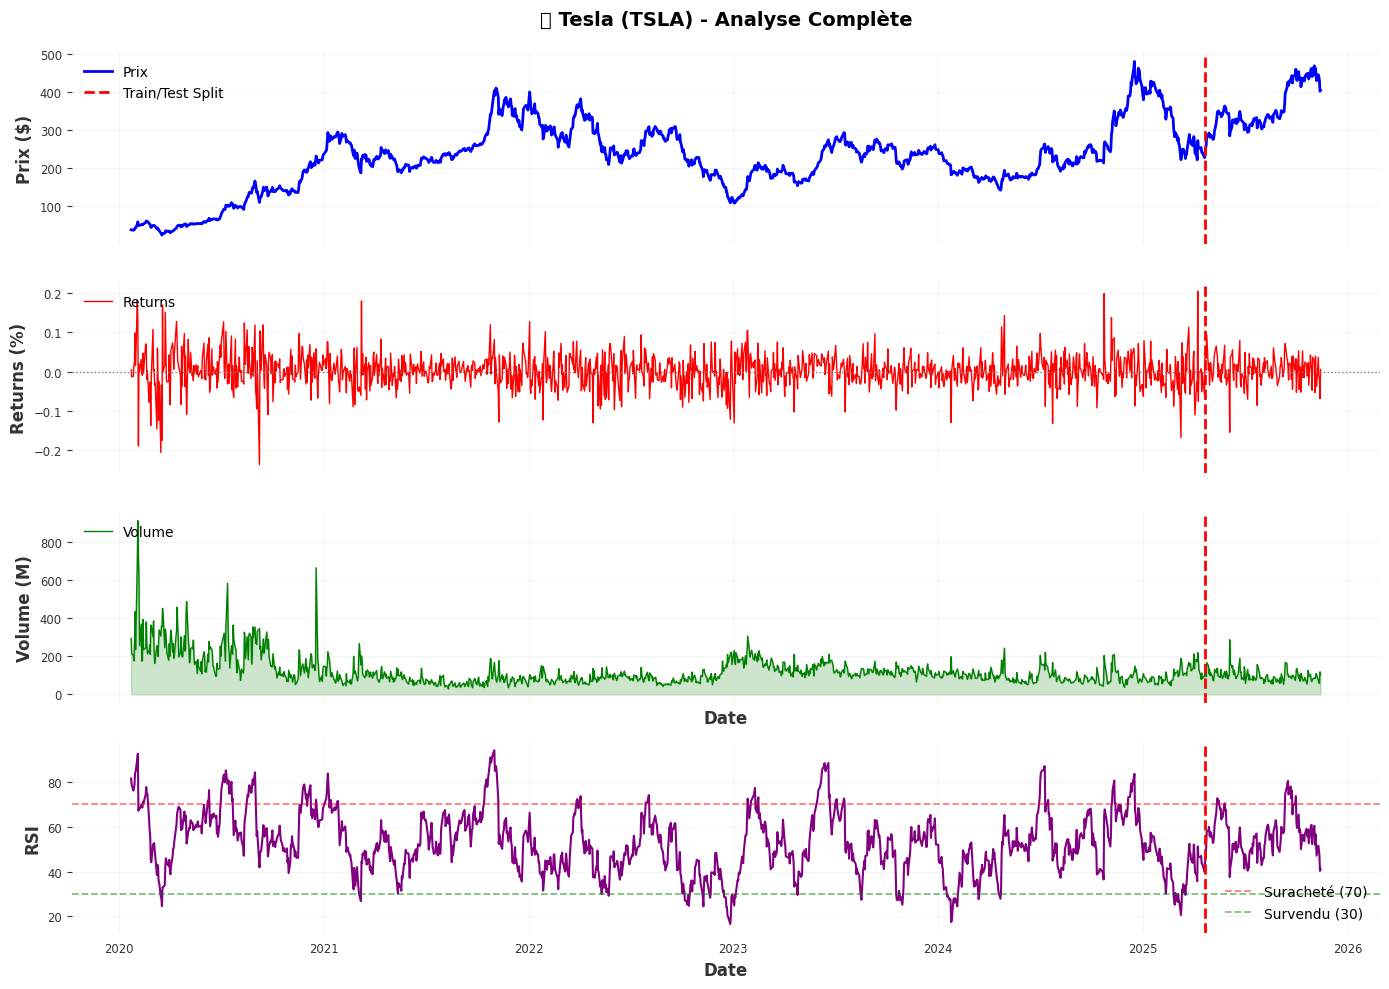

In [8]:

fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)

split_date = pd.to_datetime(test_tesla['Date'].iloc[0])

# 1. PRIX : 
axes[0].plot(tsla_data['Date'], tsla_data['Close'], color='blue', linewidth=2, label='Prix')
axes[0].axvline(split_date, color='red', linestyle='--', linewidth=2, label='Train/Test Split')
axes[0].set_ylabel('Prix ($)', fontsize=12, fontweight='bold')
axes[0].set_title('📈 Tesla (TSLA) - Analyse Complète', fontsize=14, fontweight='bold', pad=20)
axes[0].legend(loc='upper left')
axes[0].grid(True, alpha=0.3)

# 2. RENDEMENTS : 
#  est le changement du prix  d'un jour à un autre en pourcentage
axes[1].plot(tsla_data['Date'], tsla_data['Returns'], color='red', linewidth=1, label='Returns')
axes[1].axvline(split_date, color='red', linestyle='--', linewidth=2)
axes[1].axhline(0, color='gray', linestyle=':', linewidth=1)
axes[1].set_ylabel('Returns (%)', fontsize=12, fontweight='bold')
axes[1].legend(loc='upper left')
axes[1].grid(True, alpha=0.3)

# 3. VOLUME
# volume est le nombre d'actions échangées pendant une période donnée
axes[2].plot(tsla_data['Date'], tsla_data['Volume']/1e6, color='green', linewidth=1, label='Volume')
axes[2].fill_between(tsla_data['Date'], 0, tsla_data['Volume']/1e6, alpha=0.2, color='green')
axes[2].axvline(split_date, color='red', linestyle='--', linewidth=2)
axes[2].set_ylabel('Volume (M)', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Date', fontsize=12, fontweight='bold')
axes[2].legend(loc='upper left')
axes[2].grid(True, alpha=0.3)

# 4. RSI 
#est la vitesse et le changement des mouvements de prix
axes[3].plot(tsla_data['Date'], tsla_data['RSI'], color='purple', linewidth=1.5)
axes[3].axhline(70, color='red', linestyle='--', alpha=0.5, label='Suracheté (70)')
axes[3].axhline(30, color='green', linestyle='--', alpha=0.5, label='Survendu (30)')
axes[3].axvline(split_date, color='red', linestyle='--', linewidth=2)
axes[3].set_ylabel('RSI', fontsize=12, fontweight='bold')
axes[3].set_xlabel('Date', fontsize=12, fontweight='bold')
axes[3].legend()
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()





#### Preparation des données pour LSTM

In [9]:
train_tesla.head(5)

,Date,Open,High,Low,Close,Volume,Adjusted,Returns,Volume_Change,Price_Range,RSI
0,2020-01-23,37.616669,38.799999,37.040001,38.146667,294765000.0,38.146667,0.004624,-0.467692,0.046138,81.575907
1,2020-01-24,38.042000,38.257332,36.950668,37.654667,215304000.0,37.654667,-0.012981,-0.314127,0.034701,78.789833
2,2020-01-27,36.132668,37.629333,35.952000,37.201332,204121500.0,37.201332,-0.012112,-0.053336,0.045088,76.207187
3,2020-01-28,37.899334,38.453999,37.205334,37.793331,176827500.0,37.793331,0.015788,-0.143541,0.033039,77.255654
4,2020-01-29,38.379333,39.320000,37.828667,38.732666,267022500.0,38.732666,0.024551,0.412158,0.038503,78.848365


In [59]:
train_returns = train_tesla['Returns'].values.reshape(-1, 1)
from sklearn.preprocessing import StandardScaler
scaler_ret = StandardScaler()
train_returns_scaled = scaler_ret.fit_transform(train_returns)

In [60]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, lookback=60):
        self.data = data
        self.lookback = lookback
        
    def __len__(self):
        return len(self.data) - self.lookback
    
    def __getitem__(self, idx):
        X = self.data[idx:idx + self.lookback]
        y = self.data[idx + self.lookback]
        return torch.FloatTensor(X), torch.FloatTensor(y)


In [61]:
LOOKBACK = 60
BATCH_SIZE = 32
EPOCHS = 200



In [63]:
dataset = TimeSeriesDataset(train_returns_scaled, lookback=LOOKBACK)
train_size = int(0.9 * len(dataset))

train_dataset = torch.utils.data.Subset(dataset, range(0, train_size))
val_dataset = torch.utils.data.Subset(dataset, range(train_size, len(dataset)))

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


### Model LSTM

In [64]:

class SimpleLSTM(nn.Module):
    def __init__(self,input_size=1, hidden_size=64, num_layers=2, dropout=0.2):
        super(SimpleLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                           batch_first=True, dropout=dropout if num_layers > 1 else 0)
        
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        
        return out

device = torch.device('cpu')

lstm_model = SimpleLSTM(input_size=1,hidden_size=64, num_layers=2, dropout=0.2).to(device)
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.0005)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=15)


In [65]:
train_losses = []
val_losses = []
train_accuracy = []
val_accuracy = []
best_val_loss = float('inf')
best_model_state = None
best_epoch = 0
patience = 30
patience_counter = 0


for epoch in range(EPOCHS):
    
    # TRAINING
    lstm_model.train()
    train_loss = 0
    train_acc = 0
    train_batches = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = lstm_model(X_batch)
        loss = nn.MSELoss()(outputs, y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(lstm_model.parameters(), max_norm=1.0)
        optimizer.step()
        
        train_loss += loss.item()

        # Direction accuracy
        with torch.no_grad():
            if len(y_batch) > 1:
                y_true_changes = torch.diff(y_batch.squeeze())
                y_pred_changes = torch.diff(outputs.squeeze())
                correct = (torch.sign(y_true_changes) == torch.sign(y_pred_changes)).float()
                train_acc += correct.mean().item() * 100
                train_batches += 1
    
    train_loss /= len(train_loader)
    train_acc = train_acc / train_batches if train_batches > 0 else 0

    # VALIDATION
    lstm_model.eval()
    val_loss = 0
    val_acc = 0
    val_batches = 0
    
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = lstm_model(X_batch)
            loss = nn.MSELoss()(outputs, y_batch)
            val_loss += loss.item()
            
            if len(y_batch) > 1:
                y_true_changes = torch.diff(y_batch.squeeze())
                y_pred_changes = torch.diff(outputs.squeeze())
                correct = (torch.sign(y_true_changes) == torch.sign(y_pred_changes)).float()
                val_acc += correct.mean().item() * 100
                val_batches += 1
    
    val_loss /= len(val_loader)
    val_acc = val_acc / val_batches if val_batches > 0 else 0

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracy.append(train_acc)
    val_accuracy.append(val_acc)

    # Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch + 1
        best_model_state = lstm_model.state_dict().copy()
        patience_counter = 0
        status = "✅"
    else:
        patience_counter += 1
        status = f"⏸️ ({patience_counter}/{patience})"
    
    scheduler.step(val_loss)
    
    # Print tous les 5 epochs
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:3d} | Train Loss:{train_loss:.6f} | Val Loss:{val_loss:.6f} | "
              f"Train Acc:{train_acc:5.2f}% | Val Acc:{val_acc:5.2f}%")
    
    if patience_counter >= patience:
        print(f"\n🛑 Early stopping à l'epoch {epoch+1}")
        break

if best_model_state:
    lstm_model.load_state_dict(best_model_state)
    print(f"\n✅ Meilleur modèle chargé (epoch {best_epoch}, train_acc={train_acc:.6f})")

Epoch   1 | Train Loss:0.827227 | Val Loss:1.441741 | Train Acc:54.08% | Val Acc:72.02%
Epoch   5 | Train Loss:0.824871 | Val Loss:1.443107 | Train Acc:47.81% | Val Acc:44.22%
Epoch  10 | Train Loss:0.822284 | Val Loss:1.447105 | Train Acc:51.58% | Val Acc:56.65%
Epoch  15 | Train Loss:0.816716 | Val Loss:1.448468 | Train Acc:59.01% | Val Acc:62.99%
Epoch  20 | Train Loss:0.805902 | Val Loss:1.446368 | Train Acc:58.74% | Val Acc:62.24%
Epoch  25 | Train Loss:0.799363 | Val Loss:1.445733 | Train Acc:61.05% | Val Acc:59.71%
Epoch  30 | Train Loss:0.789489 | Val Loss:1.426263 | Train Acc:60.65% | Val Acc:56.65%
Epoch  35 | Train Loss:0.783942 | Val Loss:1.414879 | Train Acc:62.70% | Val Acc:58.15%
Epoch  40 | Train Loss:0.777472 | Val Loss:1.408685 | Train Acc:59.30% | Val Acc:54.12%
Epoch  45 | Train Loss:0.775047 | Val Loss:1.395060 | Train Acc:60.53% | Val Acc:55.78%
Epoch  50 | Train Loss:0.762498 | Val Loss:1.396673 | Train Acc:61.63% | Val Acc:59.01%
Epoch  55 | Train Loss:0.757691 

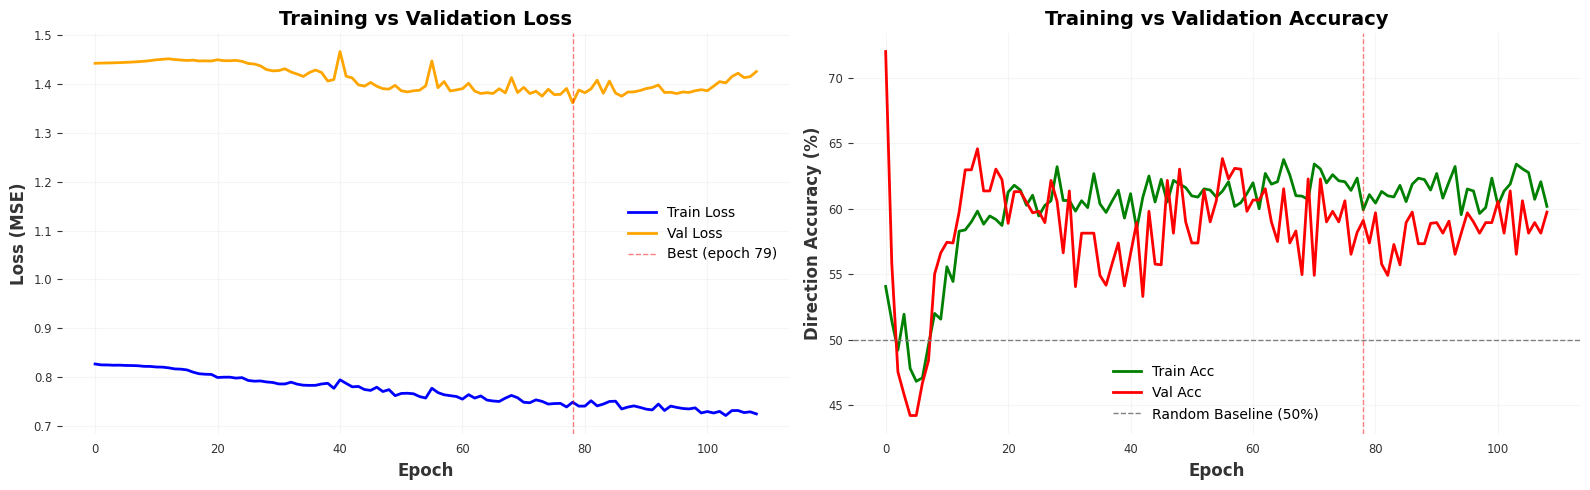

In [66]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))


axes[0].plot(train_losses, label='Train Loss', color='blue', linewidth=2)
axes[0].plot(val_losses, label='Val Loss', color='orange', linewidth=2)
axes[0].axvline(best_epoch - 1, color='red', linestyle='--', linewidth=1, alpha=0.5, label=f'Best (epoch {best_epoch})')
axes[0].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Loss (MSE)', fontsize=12, fontweight='bold')
axes[0].set_title('Training vs Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# ═══════════════════════════════════════════════════════════
# 2. ACCURACY
# ═══════════════════════════════════════════════════════════
axes[1].plot(train_accuracy, label='Train Acc', color='green', linewidth=2)
axes[1].plot(val_accuracy, label='Val Acc', color='red', linewidth=2)
axes[1].axhline(50, color='gray', linestyle='--', linewidth=1, label='Random Baseline (50%)')
axes[1].axvline(best_epoch - 1, color='red', linestyle='--', linewidth=1, alpha=0.5)
axes[1].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Direction Accuracy (%)', fontsize=12, fontweight='bold')
axes[1].set_title('Training vs Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

📊 PERFORMANCE LSTM
RMSE              : 0.0396
MAE               : 0.0303
Direction Accuracy: 44.52% (65/146)
Gain vs Random    : -5.48%


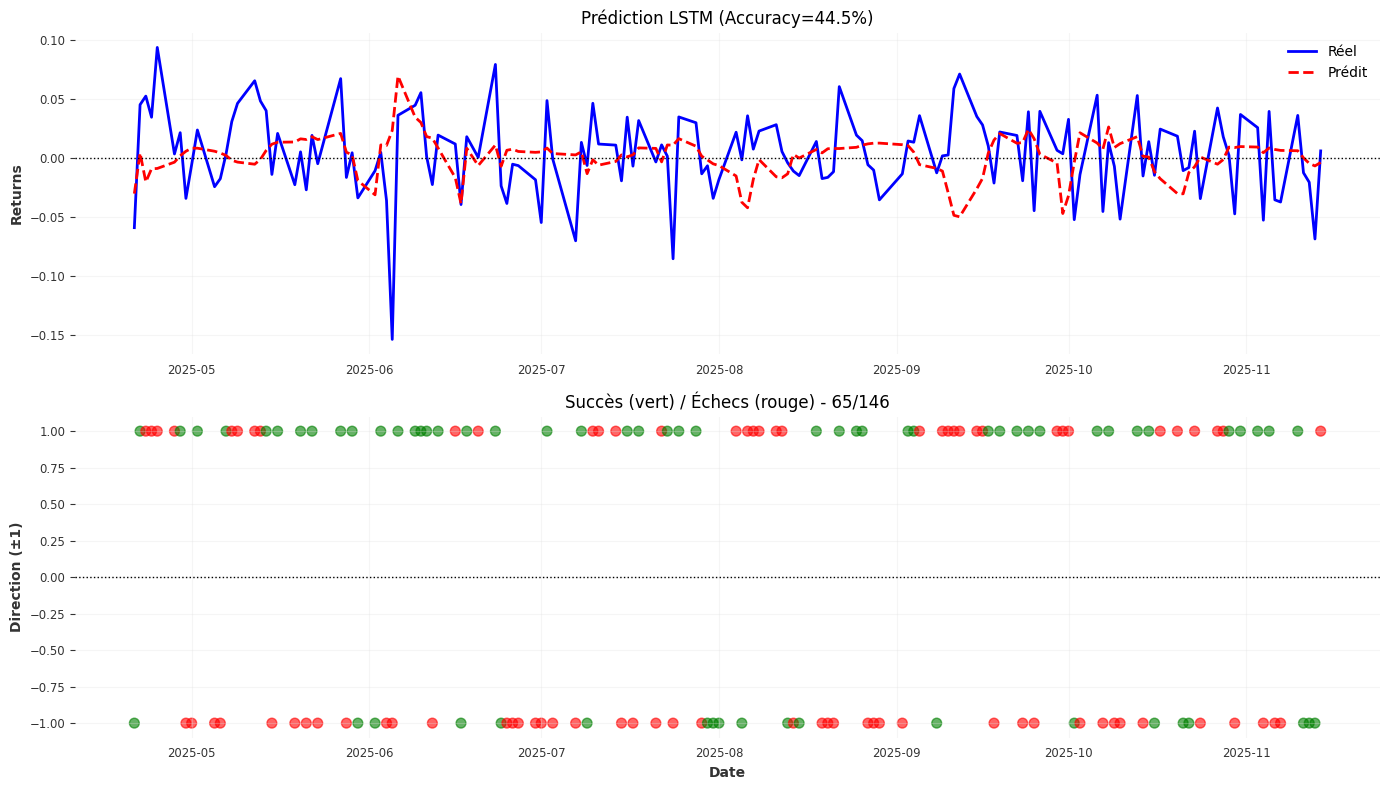

In [69]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Préparer les données
test_returns = test_tesla['Returns'].dropna().values.reshape(-1, 1)
test_scaled = scaler_ret.transform(test_returns)

last_train = train_returns_scaled[-LOOKBACK:]
all_data = np.vstack([last_train, test_scaled])

# Prédictions
predicted_returns_scaled = []
lstm_model.eval()

with torch.no_grad():
    for i in range(len(test_scaled)):
        seq = all_data[i:i+LOOKBACK]
        seq_tensor = torch.FloatTensor(seq).unsqueeze(0).to(device)
        pred = lstm_model(seq_tensor)
        predicted_returns_scaled.append(pred.cpu().numpy()[0, 0])

predicted_returns = scaler_ret.inverse_transform(
    np.array(predicted_returns_scaled).reshape(-1, 1)
).flatten()

# ✅ FIX: Aligner les tailles
actual_returns = test_returns.flatten()[:len(predicted_returns)]
actual_dates = test_tesla['Date'].values[:len(predicted_returns)]  # ← Correction ici

# Métriques
rmse = np.sqrt(mean_squared_error(actual_returns, predicted_returns))
mae = mean_absolute_error(actual_returns, predicted_returns)
direction_correct = (np.sign(actual_returns) == np.sign(predicted_returns)).sum()
direction_acc = direction_correct / len(actual_returns) * 100

print("="*80)
print("📊 PERFORMANCE LSTM")
print("="*80)
print(f"RMSE              : {rmse:.4f}")
print(f"MAE               : {mae:.4f}")
print(f"Direction Accuracy: {direction_acc:.2f}% ({direction_correct}/{len(actual_returns)})")
print(f"Gain vs Random    : {direction_acc - 50:+.2f}%")
print("="*80)

# Visualisation
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

axes[0].plot(actual_dates, actual_returns, label='Réel', color='blue', linewidth=2)
axes[0].plot(actual_dates, predicted_returns, label='Prédit', color='red', linewidth=2, linestyle='--')
axes[0].axhline(0, color='black', linestyle=':', linewidth=1)
axes[0].set_ylabel('Returns')
axes[0].set_title(f'Prédiction LSTM (Accuracy={direction_acc:.1f}%)')
axes[0].legend()
axes[0].grid(alpha=0.3)

correct_mask = (np.sign(actual_returns) == np.sign(predicted_returns))
colors = ['green' if c else 'red' for c in correct_mask]
axes[1].scatter(actual_dates, np.sign(actual_returns), c=colors, alpha=0.6, s=50)
axes[1].axhline(0, color='black', linestyle=':', linewidth=1)
axes[1].set_ylabel('Direction (±1)')
axes[1].set_xlabel('Date')
axes[1].set_title(f'Succès (vert) / Échecs (rouge) - {direction_correct}/{len(actual_returns)}')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


##### cross validation lstm

In [210]:
from sklearn.model_selection import TimeSeriesSplit

In [211]:


N_SPLITS = 5
tscv = TimeSeriesSplit(n_splits=N_SPLITS)
results_lstm = []

for fold, (train_idx, val_idx) in enumerate(tscv.split(train_returns_scaled)):
    print(f"\n===== Fold {fold+1}/{N_SPLITS} =====")
    X_train, X_val = train_returns_scaled[train_idx], train_returns_scaled[val_idx]
    ds_train = TimeSeriesDataset(X_train, lookback=LOOKBACK)
    ds_val = TimeSeriesDataset(X_val, lookback=LOOKBACK)
    train_loader = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=False)
    val_loader = DataLoader(ds_val, batch_size=BATCH_SIZE, shuffle=False)

    model = SimpleLSTM(input_size=1, hidden_size=64, num_layers=2, dropout=0.2).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)
    best_val_loss = float('inf')
    patience = 15
    patience_counter = 0

    for epoch in range(50):  # moins d'epochs pour cross-val
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = nn.MSELoss()(outputs, y_batch)
            loss.backward()
            optimizer.step()
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                val_loss += nn.MSELoss()(outputs, y_batch).item()
        val_loss /= len(val_loader)
        scheduler.step(val_loss)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
        if patience_counter >= patience:
            break
    model.load_state_dict(best_model)
    results_lstm.append(best_val_loss)
print(f"\nLSTM Cross-Validation MSE (val): {results_lstm}")
print(f"Mean: {np.mean(results_lstm):.4f} | Std: {np.std(results_lstm):.4f}")


===== Fold 1/5 =====

===== Fold 2/5 =====

===== Fold 3/5 =====

===== Fold 4/5 =====

===== Fold 5/5 =====

LSTM Cross-Validation MSE (val): [0.4616940349340439, 0.957124012708664, 0.8639946222305298, 0.5880290299654007, 1.2740960478782655]
Mean: 0.8290 | Std: 0.2859


### GRU MOdel


In [72]:
HIDDEN_SIZE = 64
NUM_LAYERS = 2
DROPOUT = 0.2
LEARNING_RATE = 0.0005
EPOCHS_GRU = 150

In [70]:
class GRUModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, output_size=1, dropout=0.2):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # GRU 
        
        self.gru = nn.GRU(input_size, hidden_size, num_layers, 
                          batch_first=True, dropout=dropout)
        
        # Couches fully connected
        self.fc1 = nn.Linear(hidden_size, 32)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(32, output_size)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        
        out, _ = self.gru(x, h0)
        out = out[:, -1, :]
        out = self.fc1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        
        return out

In [73]:
gru_model = GRUModel(input_size=1, hidden_size=HIDDEN_SIZE, 
                     num_layers=NUM_LAYERS, output_size=1, dropout=DROPOUT).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(gru_model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)


In [74]:
train_losses_gru = []
val_losses_gru = []
train_accuracy_gru = []
val_accuracy_gru = []
best_val_loss = float('inf')
best_model_state_gru = None
best_epoch_gru = 0
patience = 30
patience_counter = 0

for epoch in range(EPOCHS_GRU):
    # TRAINING
    gru_model.train()
    train_loss = 0
    train_acc = 0
    train_batches = 0
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = gru_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(gru_model.parameters(), max_norm=1.0)
        optimizer.step()
        train_loss += loss.item()
        
        # Direction accuracy
        with torch.no_grad():
            if len(y_batch) > 1:
                y_true_changes = torch.diff(y_batch.squeeze())
                y_pred_changes = torch.diff(outputs.squeeze())
                correct = (torch.sign(y_true_changes) == torch.sign(y_pred_changes)).float()
                train_acc += correct.mean().item() * 100
                train_batches += 1
    
    train_loss /= len(train_loader)
    train_acc = train_acc / train_batches if train_batches > 0 else 0
    
    # VALIDATION
    gru_model.eval()
    val_loss = 0
    val_acc = 0
    val_batches = 0
    
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = gru_model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            
            if len(y_batch) > 1:
                y_true_changes = torch.diff(y_batch.squeeze())
                y_pred_changes = torch.diff(outputs.squeeze())
                correct = (torch.sign(y_true_changes) == torch.sign(y_pred_changes)).float()
                val_acc += correct.mean().item() * 100
                val_batches += 1
    
    val_loss /= len(val_loader)
    val_acc = val_acc / val_batches if val_batches > 0 else 0
    
    train_losses_gru.append(train_loss)
    val_losses_gru.append(val_loss)
    train_accuracy_gru.append(train_acc)
    val_accuracy_gru.append(val_acc)
    
    # Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch_gru = epoch + 1
        best_model_state_gru = gru_model.state_dict().copy()
        patience_counter = 0
    else:
        patience_counter += 1
    
    scheduler.step(val_loss)
    
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:3d} | Train Loss:{train_loss:.6f} | Val Loss:{val_loss:.6f} | "
              f"Train Acc:{train_acc:5.2f}% | Val Acc:{val_acc:5.2f}%")
    
    if patience_counter >= patience:
        print(f"\n🛑 Early stopping à l'epoch {epoch+1}")
        break

gru_model.load_state_dict(best_model_state_gru)
print(f"\n✅ Meilleur modèle GRU chargé (epoch {best_epoch_gru})")

Epoch   1 | Train Loss:0.831538 | Val Loss:1.444386 | Train Acc:47.28% | Val Acc:32.76%
Epoch   5 | Train Loss:0.825907 | Val Loss:1.444040 | Train Acc:46.64% | Val Acc:45.94%
Epoch  10 | Train Loss:0.822940 | Val Loss:1.443643 | Train Acc:50.32% | Val Acc:54.98%
Epoch  15 | Train Loss:0.819355 | Val Loss:1.439418 | Train Acc:55.07% | Val Acc:60.62%
Epoch  20 | Train Loss:0.814739 | Val Loss:1.429966 | Train Acc:54.61% | Val Acc:58.95%
Epoch  25 | Train Loss:0.808559 | Val Loss:1.427595 | Train Acc:55.52% | Val Acc:59.82%
Epoch  30 | Train Loss:0.797260 | Val Loss:1.412812 | Train Acc:57.49% | Val Acc:61.54%
Epoch  35 | Train Loss:0.795138 | Val Loss:1.406457 | Train Acc:52.81% | Val Acc:63.15%
Epoch  40 | Train Loss:0.793542 | Val Loss:1.397934 | Train Acc:54.72% | Val Acc:63.90%
Epoch  45 | Train Loss:0.788573 | Val Loss:1.394278 | Train Acc:55.32% | Val Acc:63.10%
Epoch  50 | Train Loss:0.789911 | Val Loss:1.393304 | Train Acc:56.95% | Val Acc:65.52%
Epoch  55 | Train Loss:0.782061 

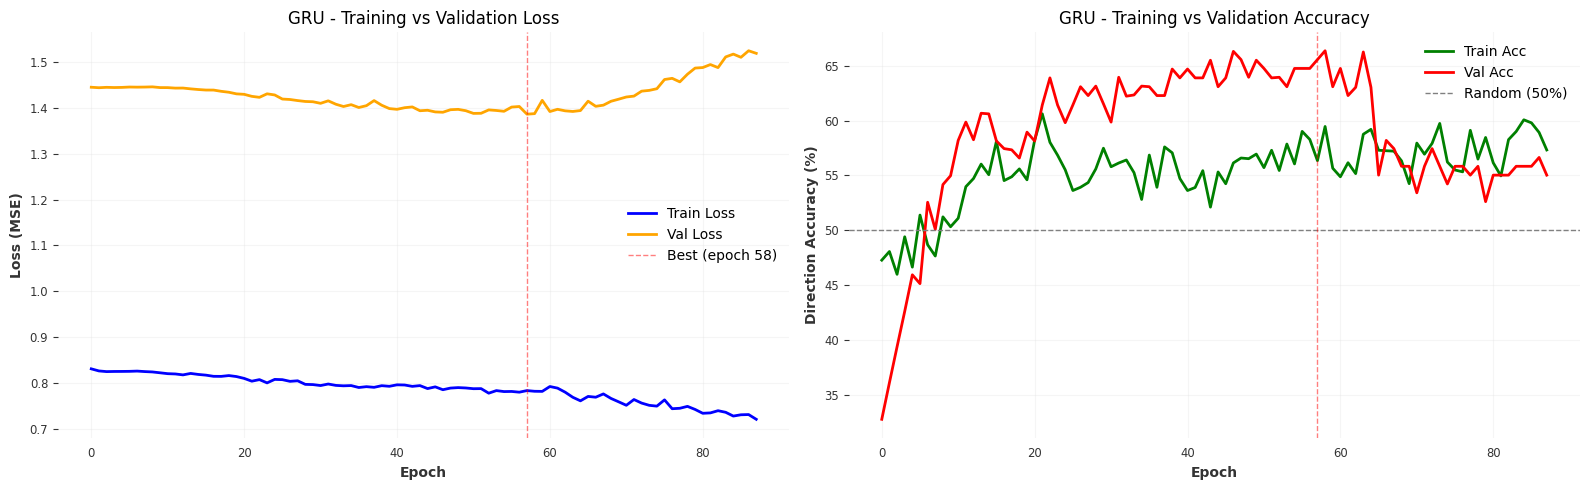

In [76]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Loss
axes[0].plot(train_losses_gru, label='Train Loss', color='blue', linewidth=2)
axes[0].plot(val_losses_gru, label='Val Loss', color='orange', linewidth=2)
axes[0].axvline(best_epoch_gru - 1, color='red', linestyle='--', linewidth=1, alpha=0.5, 
                label=f'Best (epoch {best_epoch_gru})')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].set_title('GRU - Training vs Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(train_accuracy_gru, label='Train Acc', color='green', linewidth=2)
axes[1].plot(val_accuracy_gru, label='Val Acc', color='red', linewidth=2)
axes[1].axhline(50, color='gray', linestyle='--', linewidth=1, label='Random (50%)')
axes[1].axvline(best_epoch_gru - 1, color='red', linestyle='--', linewidth=1, alpha=0.5)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Direction Accuracy (%)')
axes[1].set_title('GRU - Training vs Validation Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

📊 PERFORMANCE GRU
RMSE              : 0.0364
MAE               : 0.0272
Direction Accuracy: 52.05% (76/146)
Gain vs Random    : +2.05%


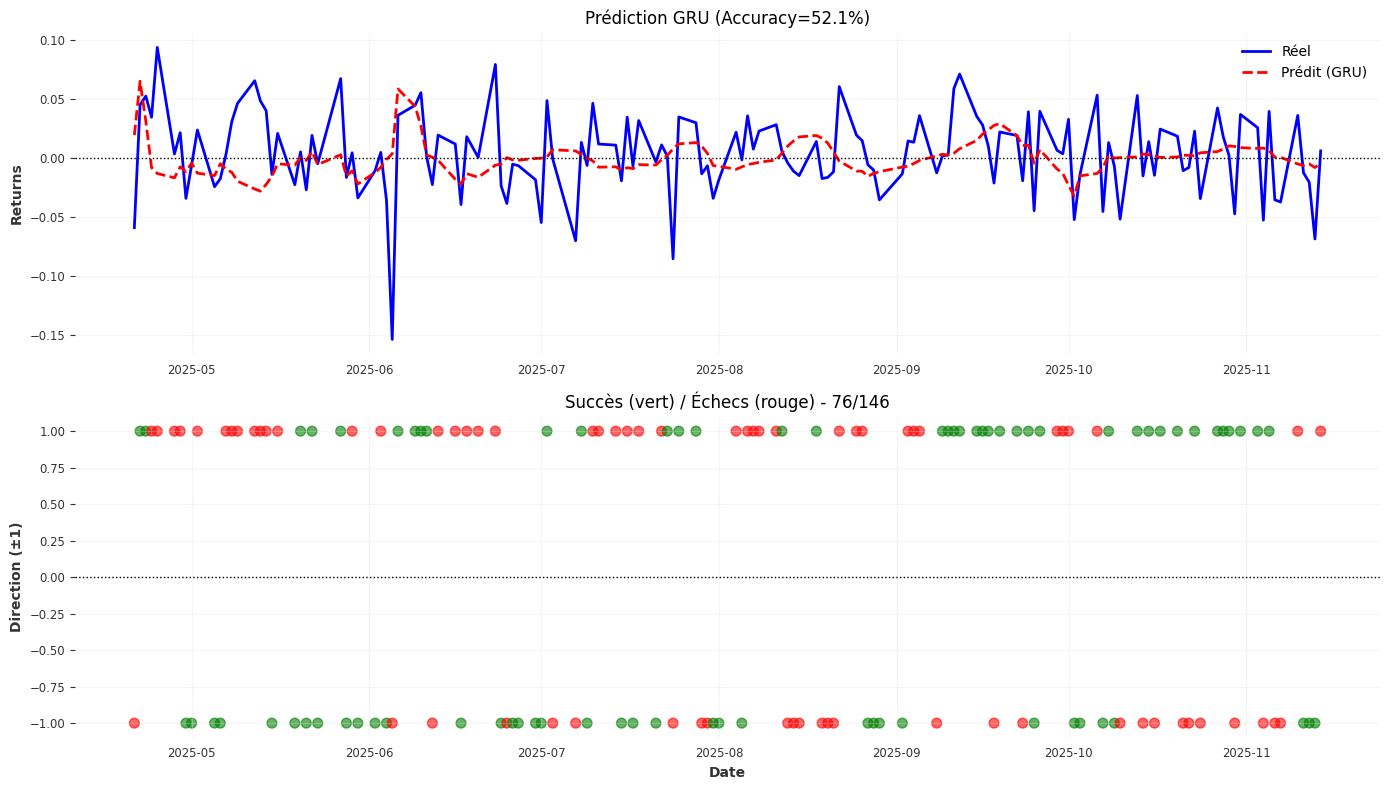

In [79]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Préparer les données
test_returns = test_tesla['Returns'].dropna().values.reshape(-1, 1)
test_scaled = scaler_ret.transform(test_returns)

last_train = train_returns_scaled[-LOOKBACK:]
all_data = np.vstack([last_train, test_scaled])

# Prédictions
predicted_returns_scaled = []
gru_model.eval()

with torch.no_grad():
    for i in range(len(test_scaled)):
        seq = all_data[i:i+LOOKBACK]
        seq_tensor = torch.FloatTensor(seq).unsqueeze(0).to(device)
        pred = gru_model(seq_tensor)
        predicted_returns_scaled.append(pred.cpu().numpy()[0, 0])

predicted_returns = scaler_ret.inverse_transform(
    np.array(predicted_returns_scaled).reshape(-1, 1)
).flatten()

actual_returns = test_returns.flatten()[:len(predicted_returns)]
actual_dates = test_tesla['Date'].values[:len(predicted_returns)]

# Métriques
rmse = np.sqrt(mean_squared_error(actual_returns, predicted_returns))
mae = mean_absolute_error(actual_returns, predicted_returns)
direction_correct = (np.sign(actual_returns) == np.sign(predicted_returns)).sum()
direction_acc = direction_correct / len(actual_returns) * 100

print("="*80)
print("📊 PERFORMANCE GRU")
print("="*80)
print(f"RMSE              : {rmse:.4f}")
print(f"MAE               : {mae:.4f}")
print(f"Direction Accuracy: {direction_acc:.2f}% ({direction_correct}/{len(actual_returns)})")
print(f"Gain vs Random    : {direction_acc - 50:+.2f}%")
print("="*80)

# Visualisation
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

axes[0].plot(actual_dates, actual_returns, label='Réel', color='blue', linewidth=2)
axes[0].plot(actual_dates, predicted_returns, label='Prédit (GRU)', color='red', linewidth=2, linestyle='--')
axes[0].axhline(0, color='black', linestyle=':', linewidth=1)
axes[0].set_ylabel('Returns')
axes[0].set_title(f'Prédiction GRU (Accuracy={direction_acc:.1f}%)')
axes[0].legend()
axes[0].grid(alpha=0.3)

correct_mask = (np.sign(actual_returns) == np.sign(predicted_returns))
colors = ['green' if c else 'red' for c in correct_mask]
axes[1].scatter(actual_dates, np.sign(actual_returns), c=colors, alpha=0.6, s=50)
axes[1].axhline(0, color='black', linestyle=':', linewidth=1)
axes[1].set_ylabel('Direction (±1)')
axes[1].set_xlabel('Date')
axes[1].set_title(f'Succès (vert) / Échecs (rouge) - {direction_correct}/{len(actual_returns)}')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


##### Cross validation gru

In [214]:
results_gru = []
for fold, (train_idx, val_idx) in enumerate(tscv.split(train_returns_scaled)):
    print(f"\n===== Fold {fold+1}/{tscv.n_splits} =====")
    X_train, X_val = train_returns_scaled[train_idx], train_returns_scaled[val_idx]
    ds_train = TimeSeriesDataset(X_train, lookback=LOOKBACK)
    ds_val = TimeSeriesDataset(X_val, lookback=LOOKBACK)
    train_loader = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=False)
    val_loader = DataLoader(ds_val, batch_size=BATCH_SIZE, shuffle=False)

    model = GRUModel(input_size=1, hidden_size=64, num_layers=2, output_size=1, dropout=0.2).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    best_val_loss = float('inf')
    patience = 7
    patience_counter = 0

    for epoch in range(20):  # epochs réduits
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = nn.MSELoss()(outputs, y_batch)
            loss.backward()
            optimizer.step()
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                val_loss += nn.MSELoss()(outputs, y_batch).item()
        val_loss /= len(val_loader)
        scheduler.step(val_loss)
        print(f"Epoch {epoch+1} | Val Loss: {val_loss:.4f}")
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping.")
            break
    model.load_state_dict(best_model)
    results_gru.append(best_val_loss)
print(f"\nGRU Cross-Validation MSE (val): {results_gru}")
print(f"Mean: {np.mean(results_gru):.4f} | Std: {np.std(results_gru):.4f}")


===== Fold 1/5 =====
Epoch 1 | Val Loss: 0.4526
Epoch 2 | Val Loss: 0.4562
Epoch 3 | Val Loss: 0.4642
Epoch 4 | Val Loss: 0.4756
Epoch 5 | Val Loss: 0.4920
Epoch 6 | Val Loss: 0.5106
Epoch 7 | Val Loss: 0.5243
Epoch 8 | Val Loss: 0.5265
Early stopping.

===== Fold 2/5 =====
Epoch 1 | Val Loss: 0.9554
Epoch 2 | Val Loss: 0.9582
Epoch 3 | Val Loss: 0.9584
Epoch 4 | Val Loss: 0.9592
Epoch 5 | Val Loss: 0.9593
Epoch 6 | Val Loss: 0.9576
Epoch 7 | Val Loss: 0.9592
Epoch 8 | Val Loss: 0.9592
Early stopping.

===== Fold 3/5 =====
Epoch 1 | Val Loss: 0.8657
Epoch 2 | Val Loss: 0.8659
Epoch 3 | Val Loss: 0.8655
Epoch 4 | Val Loss: 0.8660
Epoch 5 | Val Loss: 0.8666
Epoch 6 | Val Loss: 0.8654
Epoch 7 | Val Loss: 0.8675
Epoch 8 | Val Loss: 0.8674
Epoch 9 | Val Loss: 0.8674
Epoch 10 | Val Loss: 0.8676
Epoch 11 | Val Loss: 0.8680
Epoch 12 | Val Loss: 0.8711
Epoch 13 | Val Loss: 0.8732
Early stopping.

===== Fold 4/5 =====
Epoch 1 | Val Loss: 0.5855
Epoch 2 | Val Loss: 0.5872
Epoch 3 | Val Loss: 0.5

### ARIMA-LSTM

In [80]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [194]:
class ARIMA_LSTM:
    def __init__(self, arima_order=(1,0,1), lstm_hidden=64, lstm_layers=2, 
                 lookback=60, device='cpu'):
        self.arima_order = arima_order
        self.lstm_hidden = lstm_hidden
        self.lstm_layers = lstm_layers
        self.lookback = lookback
        self.device = device
        
        self.arima_fitted = None
        self.lstm_model = None
        self.scaler = MinMaxScaler()
        self.train_data = None
        
        self.history = {
            'train_losses': [],
            'val_losses': [],
            'train_accuracy': [],
            'val_accuracy': []
        }
    
    def fit_arima(self, train_data):
        """Fit ARIMA model and return residuals"""
        if isinstance(train_data, pd.Series):
            self.train_data = train_data.values.copy()
        else:
            self.train_data = train_data.copy()
        
        model = ARIMA(self.train_data, order=self.arima_order)
        self.arima_fitted = model.fit()
        
        print("\n" + "="*80)
        print("📊 ARIMA MODEL SUMMARY")
        print("="*80)
        print(f"Order             : ARIMA{self.arima_order}")
        print(f"AIC               : {self.arima_fitted.aic:.2f}")
        print(f"BIC               : {self.arima_fitted.bic:.2f}")
        print(f"HQIC              : {self.arima_fitted.hqic:.2f}")
        print(f"Log-Likelihood    : {self.arima_fitted.llf:.2f}")
        
        print("\n📈 Coefficients & P-values:")
        params = self.arima_fitted.params
        pvalues = self.arima_fitted.pvalues
        
        for i, (param, pval) in enumerate(zip(params, pvalues)):
            sig = "***" if pval < 0.001 else "**" if pval < 0.01 else "*" if pval < 0.05 else ""
            print(f"  Param {i}: {param:8.4f} (p={pval:.4f}) {sig}")
        print("="*80)
        
        residuals = self.train_data - self.arima_fitted.fittedvalues
        return residuals
    
    def build_lstm(self):
        """Build LSTM model"""
        self.lstm_model = SimpleLSTM(
            input_size=1,
            hidden_size=self.lstm_hidden,
            num_layers=self.lstm_layers,
            dropout=0.2
        ).to(self.device)
    
    def train_lstm(self, residuals, epochs=100, batch_size=32, lr=0.0001):

        if isinstance(residuals, pd.Series):
            residuals = residuals.values
        
        residuals_scaled = self.scaler.fit_transform(residuals.reshape(-1, 1))
        
        dataset = TimeSeriesDataset(residuals_scaled, lookback=self.lookback)
        train_size = int(0.9 * len(dataset))
        
        train_ds = torch.utils.data.Subset(dataset, range(0, train_size))
        val_ds = torch.utils.data.Subset(dataset, range(train_size, len(dataset)))
        
        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=False)
        val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
        
        self.build_lstm()
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(self.lstm_model.parameters(), lr=lr, weight_decay=1e-5)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=10
        )
        
        best_val_loss = float('inf')
        best_state = None
        best_epoch = 0
        patience = 20
        patience_counter = 0
        
        for epoch in range(epochs):
            # ========== TRAINING ==========
            self.lstm_model.train()
            train_loss = 0
            train_acc = 0
            train_batches = 0
            
            for X, y in train_loader:
                X, y = X.to(self.device), y.to(self.device)
                
                optimizer.zero_grad()
                out = self.lstm_model(X)
                loss = criterion(out, y)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.lstm_model.parameters(), 1.0)
                optimizer.step()
                
                train_loss += loss.item()
                
                # Direction accuracy
                with torch.no_grad():
                    if len(y) > 1:
                        y_true_changes = torch.diff(y.squeeze())
                        y_pred_changes = torch.diff(out.squeeze())
                        correct = (torch.sign(y_true_changes) == torch.sign(y_pred_changes)).float()
                        train_acc += correct.mean().item() * 100
                        train_batches += 1
            
            train_loss /= len(train_loader)
            train_acc = train_acc / train_batches if train_batches > 0 else 0
            
            # ========== VALIDATION ==========
            self.lstm_model.eval()
            val_loss = 0
            val_acc = 0
            val_batches = 0
            
            with torch.no_grad():
                for X, y in val_loader:
                    X, y = X.to(self.device), y.to(self.device)
                    out = self.lstm_model(X)
                    val_loss += criterion(out, y).item()
                    
                    # Direction accuracy
                    if len(y) > 1:
                        y_true_changes = torch.diff(y.squeeze())
                        y_pred_changes = torch.diff(out.squeeze())
                        correct = (torch.sign(y_true_changes) == torch.sign(y_pred_changes)).float()
                        val_acc += correct.mean().item() * 100
                        val_batches += 1
            
            val_loss /= len(val_loader)
            val_acc = val_acc / val_batches if val_batches > 0 else 0
            
            # Sauvegarder l'historique
            self.history['train_losses'].append(train_loss)
            self.history['val_losses'].append(val_loss)
            self.history['train_accuracy'].append(train_acc)
            self.history['val_accuracy'].append(val_acc)
            
            # Meilleur modèle + Early Stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_state = self.lstm_model.state_dict().copy()
                best_epoch = epoch + 1
                patience_counter = 0
                status = "✅"
            else:
                patience_counter += 1
                status = f"⏸️ ({patience_counter}/{patience})"
            
            scheduler.step(val_loss)
            
            # Print tous les 10 epochs
            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch+1:3d}/{epochs} | "
                      f"Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f} | "
                      f"Train Acc: {train_acc:5.2f}% | Val Acc: {val_acc:5.2f}% | {status}")
            
            # Early stopping
            if patience_counter >= patience:
                print(f"\n🛑 Early stopping at epoch {epoch+1}")
                break
        
        # Charger le meilleur modèle
        if best_state:
            self.lstm_model.load_state_dict(best_state)
        
        print("\n" + "="*80)
        print("📊 LSTM TRAINING SUMMARY")
        print("="*80)
        print(f"Best epoch        : {best_epoch}")
        print(f"Best val loss     : {best_val_loss:.6f}")
        print(f"Best val accuracy : {self.history['val_accuracy'][best_epoch-1]:.2f}%")
        print(f"Final train loss  : {self.history['train_losses'][-1]:.6f}")
        print(f"Final train acc   : {self.history['train_accuracy'][-1]:.2f}%")
        print(f"Gain vs Random    : {self.history['val_accuracy'][best_epoch-1] - 50:+.2f}%")
        print("="*80)
    
    def predict(self, n_steps, update_arima=False):
        """Predict future values"""
        print(f"\n🔮 Predicting {n_steps} steps...")
        predictions = []
        current_data = list(self.train_data)
        
        for i in range(n_steps):
            if i % 20 == 0 and i > 0:
                print(f"   Step {i}/{n_steps}...")
            
            if update_arima and i > 0:
                temp_model = ARIMA(current_data, order=self.arima_order)
                temp_fitted = temp_model.fit()
            else:
                temp_fitted = self.arima_fitted
            
            arima_pred = temp_fitted.forecast(steps=1)[0]
            
            lstm_corr = 0
            if len(temp_fitted.resid) >= self.lookback:
                resid = np.array(temp_fitted.resid)[-self.lookback:]
                resid_scaled = self.scaler.transform(resid.reshape(-1, 1))
                seq = torch.FloatTensor(resid_scaled).unsqueeze(0).to(self.device)
                
                self.lstm_model.eval()
                with torch.no_grad():
                    lstm_corr = self.lstm_model(seq).cpu().numpy()[0, 0]
                    lstm_corr = self.scaler.inverse_transform([[lstm_corr]])[0, 0]
            
            final_pred = arima_pred + lstm_corr
            current_data.append(final_pred)
            predictions.append(final_pred)
        
        print("✅ Prediction complete!\n")
        return np.array(predictions)
    
    def plot_training_history(self):
        """Visualiser l'historique d'entraînement LSTM"""
        fig, axes = plt.subplots(1, 2, figsize=(16, 5))
        
        # Loss
        axes[0].plot(self.history['train_losses'], label='Train Loss', color='blue', linewidth=2)
        axes[0].plot(self.history['val_losses'], label='Val Loss', color='orange', linewidth=2)
        best_epoch = np.argmin(self.history['val_losses']) + 1
        axes[0].axvline(best_epoch - 1, color='red', linestyle='--', linewidth=1, alpha=0.5,
                       label=f'Best (epoch {best_epoch})')
        axes[0].set_xlabel('Epoch', fontsize=12, fontweight='bold')
        axes[0].set_ylabel('Loss (MSE)', fontsize=12, fontweight='bold')
        axes[0].set_title('LSTM - Training vs Validation Loss', fontsize=14, fontweight='bold')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Accuracy
        axes[1].plot(self.history['train_accuracy'], label='Train Acc', color='green', linewidth=2)
        axes[1].plot(self.history['val_accuracy'], label='Val Acc', color='red', linewidth=2)
        axes[1].axhline(50, color='gray', linestyle='--', linewidth=1, label='Random (50%)')
        axes[1].axvline(best_epoch - 1, color='red', linestyle='--', linewidth=1, alpha=0.5)
        axes[1].set_xlabel('Epoch', fontsize=12, fontweight='bold')
        axes[1].set_ylabel('Direction Accuracy (%)', fontsize=12, fontweight='bold')
        axes[1].set_title('LSTM - Training vs Validation Accuracy', fontsize=14, fontweight='bold')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def evaluate(self, test_data):
        """Evaluate model on test data"""
        preds = self.predict(len(test_data), update_arima=False)
        
        if isinstance(test_data, pd.DataFrame):
            actual = test_data['Returns'].values[:len(preds)]
            dates = test_data['Date'].values[:len(preds)]
        else:
            actual = test_data[:len(preds)]
            dates = np.arange(len(actual))
        
        rmse_val = np.sqrt(mean_squared_error(actual, preds))
        mae_val = mean_absolute_error(actual, preds)
        mape_val = np.mean(np.abs((actual - preds) / (actual + 1e-8))) * 100
        
        actual_dir = np.diff(actual)
        pred_dir = np.diff(preds)
        dir_acc = (np.sign(actual_dir) == np.sign(pred_dir)).sum() / len(actual_dir) * 100
        
        print("="*80)
        print("📊 ARIMA-LSTM PERFORMANCE")
        print("="*80)
        print(f"RMSE              : {rmse_val:.4f}")
        print(f"MAE               : {mae_val:.4f}")
        print(f"MAPE              : {mape_val:.2f}%")
        print(f"Direction Accuracy: {dir_acc:.2f}%")
        print(f"Gain vs Random    : {dir_acc - 50:+.2f}%")
        print("="*80)
        
        # Plot
        fig, axes = plt.subplots(2, 1, figsize=(10, 8))
        
        axes[0].plot(dates, actual, label='Réel', color='blue', linewidth=2)
        axes[0].plot(dates, preds, label='Prédit', color='red', linewidth=2, linestyle='--')
        axes[0].axhline(0, color='black', linestyle=':', linewidth=1)
        axes[0].set_ylabel('Returns', fontsize=12, fontweight='bold')
        axes[0].set_title(f'ARIMA-LSTM Predictions (MAPE={mape_val:.2f}%)', fontsize=14, fontweight='bold')
        axes[0].legend()
        axes[0].grid(alpha=0.3)

        
        plt.tight_layout()
        plt.show()

In [159]:
# 1. nitialiser
hybrid_model = ARIMA_LSTM(
    arima_order=(1, 0, 1),
    lstm_hidden=64,
    lstm_layers=2,
    lookback=60,
    device='cpu'
)

In [160]:

residuals = hybrid_model.fit_arima(train_tesla['Returns'])


📊 ARIMA MODEL SUMMARY
Order             : ARIMA(1, 0, 1)
AIC               : -4552.61
BIC               : -4531.88
HQIC              : -4544.84
Log-Likelihood    : 2280.31

📈 Coefficients & P-values:
  Param 0:   0.0014 (p=0.2414) 
  Param 1:   0.3195 (p=0.9873) 
  Param 2:  -0.3205 (p=0.9872) 
  Param 3:   0.0018 (p=0.0000) ***


In [161]:
hybrid_model.train_lstm(
    residuals, 
    epochs=100,
    batch_size=32,
    lr=0.0005
)

Epoch  10/100 | Train Loss: 0.008091 | Val Loss: 0.013667 | Train Acc: 47.02% | Val Acc: 33.73% | ⏸️ (3/20)
Epoch  20/100 | Train Loss: 0.007987 | Val Loss: 0.013640 | Train Acc: 48.43% | Val Acc: 33.62% | ⏸️ (1/20)
Epoch  30/100 | Train Loss: 0.007947 | Val Loss: 0.013631 | Train Acc: 48.71% | Val Acc: 31.95% | ⏸️ (2/20)
Epoch  40/100 | Train Loss: 0.007958 | Val Loss: 0.013628 | Train Acc: 47.78% | Val Acc: 31.15% | ✅
Epoch  50/100 | Train Loss: 0.007873 | Val Loss: 0.013631 | Train Acc: 50.13% | Val Acc: 31.15% | ⏸️ (1/20)
Epoch  60/100 | Train Loss: 0.007819 | Val Loss: 0.013648 | Train Acc: 48.43% | Val Acc: 31.95% | ⏸️ (9/20)
Epoch  70/100 | Train Loss: 0.007822 | Val Loss: 0.013631 | Train Acc: 50.92% | Val Acc: 31.15% | ⏸️ (19/20)

🛑 Early stopping at epoch 71

📊 LSTM TRAINING SUMMARY
Best epoch        : 51
Best val loss     : 0.013627
Best val accuracy : 31.15%
Final train loss  : 0.007832
Final train acc   : 48.80%
Gain vs Random    : -18.85%


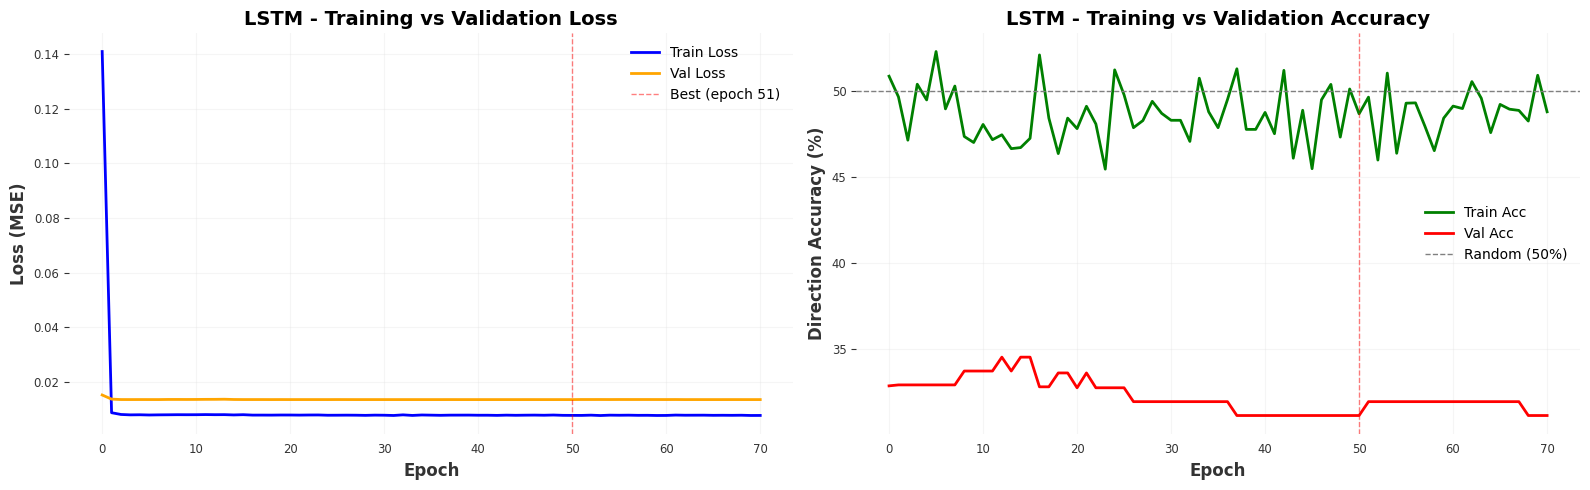

In [162]:
# 4. Visualiser l'entraînement
hybrid_model.plot_training_history()


🔮 Predicting 146 steps...
   Step 20/146...
   Step 40/146...
   Step 60/146...
   Step 80/146...
   Step 100/146...
   Step 120/146...
   Step 140/146...
✅ Prediction complete!

📊 ARIMA-LSTM PERFORMANCE
RMSE              : 0.0350
MAE               : 0.0270
MAPE              : 101.89%
Direction Accuracy: 0.00%
Gain vs Random    : -50.00%


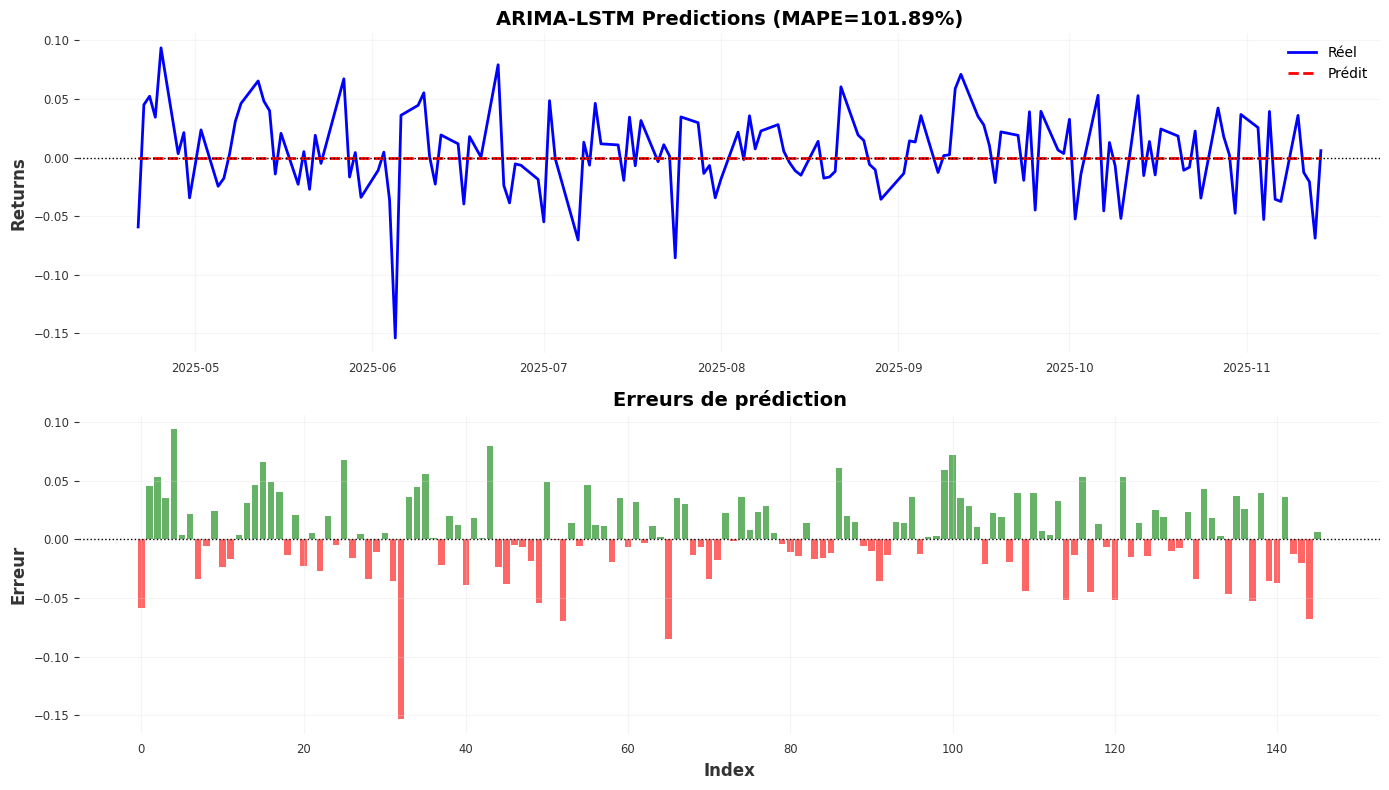

In [195]:
hybrid_model.evaluate(test_tesla)

In [ ]:
#le model lstm_arima ne capture rien , trop de bruit dans les résidus

##### cross validation lstm_arima

In [216]:
from sklearn.model_selection import TimeSeriesSplit

N_SPLITS = 5
tscv = TimeSeriesSplit(n_splits=N_SPLITS)
results_arima_lstm = []

for fold, (train_idx, val_idx) in enumerate(tscv.split(train_tesla['Returns'].values)):
    print(f"\n===== Fold {fold+1}/{N_SPLITS} =====")
    train_series = train_tesla['Returns'].values[train_idx]
    val_series = train_tesla['Returns'].values[val_idx]

    # 1. Fit ARIMA on train
    hybrid_cv = ARIMA_LSTM(
        arima_order=(1, 0, 1),
        lstm_hidden=64,
        lstm_layers=2,
        lookback=60,
        device='cpu'
    )
    residuals = hybrid_cv.fit_arima(train_series)

    # 2. Train LSTM on ARIMA residuals
    hybrid_cv.train_lstm(residuals, epochs=50, batch_size=32, lr=0.0005)

    # 3. Predict on validation set
    preds = hybrid_cv.predict(len(val_series), update_arima=False)
    actual = val_series[:len(preds)]

    # 4. Compute MSE
    mse = np.mean((actual - preds) ** 2)
    results_arima_lstm.append(mse)
    print(f"Fold {fold+1} MSE: {mse:.4f}")

print(f"\nARIMA-LSTM Cross-Validation MSE (val): {results_arima_lstm}")
print(f"Mean: {np.mean(results_arima_lstm):.4f} | Std: {np.std(results_arima_lstm):.4f}")


===== Fold 1/5 =====

📊 ARIMA MODEL SUMMARY
Order             : ARIMA(1, 0, 1)
AIC               : -622.70
BIC               : -609.09
HQIC              : -617.20
Log-Likelihood    : 315.35

📈 Coefficients & P-values:
  Param 0:   0.0078 (p=0.0583) 
  Param 1:   0.0020 (p=0.9999) 
  Param 2:   0.0020 (p=0.9999) 
  Param 3:   0.0034 (p=0.0000) ***
Epoch  10/50 | Train Loss: 0.018295 | Val Loss: 0.013569 | Train Acc: 50.00% | Val Acc: 25.00% | ⏸️ (3/20)
Epoch  20/50 | Train Loss: 0.013844 | Val Loss: 0.010514 | Train Acc: 42.22% | Val Acc: 25.00% | ⏸️ (13/20)

🛑 Early stopping at epoch 27

📊 LSTM TRAINING SUMMARY
Best epoch        : 7
Best val loss     : 0.008451
Best val accuracy : 18.75%
Final train loss  : 0.013164
Final train acc   : 57.74%
Gain vs Random    : -31.25%

🔮 Predicting 219 steps...
   Step 20/219...
   Step 40/219...
   Step 60/219...
   Step 80/219...
   Step 100/219...
   Step 120/219...
   Step 140/219...
   Step 160/219...
   Step 180/219...
   Step 200/219...
✅ Pre

### Prophet RNN Model

In [199]:

from neuralprophet import NeuralProphet
import warnings
warnings.filterwarnings('ignore')

train_prophet = train_tesla[["Date", "Returns"]].rename(columns={"Date": "ds", "Returns": "y"})
test_prophet = test_tesla[["Date", "Returns"]].rename(columns={"Date": "ds", "Returns": "y"})
train_prophet["rsi"] = train_tesla["RSI"].values
train_prophet["volume"] = train_tesla["Volume"].values
test_prophet["rsi"] = test_tesla["RSI"].values
test_prophet["volume"] = test_tesla["Volume"].values

split_idx = int(0.9 * len(train_prophet))
train_df = train_prophet.iloc[:split_idx].reset_index(drop=True)
val_df = train_prophet.iloc[split_idx:].reset_index(drop=True)

split_idx = int(0.9 * len(train_prophet))
train_df = train_prophet.iloc[:split_idx].reset_index(drop=True)
val_df = train_prophet.iloc[split_idx:].reset_index(drop=True)



In [200]:
NP_EPOCHS = 50
prophet_rnn = NeuralProphet(
    n_forecasts=1,
    n_lags=20,
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    learning_rate=0.0005,
    epochs=NP_EPOCHS,
    batch_size=32,
    loss_func="MSE",
    normalize="standardize",
    trend_reg=3,
    ar_layers=[32],
    trend_global_local="global",
)




INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.


In [201]:
prophet_rnn.add_future_regressor("rsi")
prophet_rnn.add_future_regressor("volume")


In [202]:
metrics_df = prophet_rnn.fit(train_df, freq="D", validation_df=val_df, progress="bar")

history_np = {
    "loss": metrics_df["Loss"].tolist(),
    "val_loss": metrics_df["ValLoss"].tolist() if "ValLoss" in metrics_df else [np.nan] * len(metrics_df),
}

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.287% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Added 535 missing dates.
WARNING - (NP.data.processing._handle_missing_data) - 535 missing values in column y were detected in total. 
INFO - (NP.data.processing._handle_missing_data) - 535 NaN values in column y were auto-imputed.
WARNING - (NP.data.processing._handle_missing_data) - 535 missing values in column rsi were detected in total. 
INFO - (NP.data.processing._handle_missing_data) - 535 NaN values in column rsi were auto-imputed.
WARNING - (NP.data.processing._handle_missing_data) - 535 missing values in column volume were detected in total. 
INFO - (NP.data.processing._handle_missing_data) - 535 NaN values in column volume we

Epoch 50: 100%|██████████| 50/50 [00:00<00:00, 180.50it/s, loss=0.629, v_num=9, MAE_val=0.0327, RMSE_val=0.0441, Loss_val=1.260, RegLoss_val=0.000, MAE=0.0279, RMSE=0.037, Loss=0.639, RegLoss=0.000]   


In [206]:
full_prophet = pd.concat([train_prophet, test_prophet]).reset_index(drop=True)
future = prophet_rnn.make_future_dataframe(
    df=full_prophet,
    periods=0,
    n_historic_predictions=len(train_prophet),
    regressors_df=full_prophet[["ds","rsi", "volume"]],
)
forecast = prophet_rnn.predict(future)

pred_start = len(train_prophet)
predictions_np = forecast["yhat1"].iloc[pred_start:pred_start + len(test_prophet)].to_numpy()
actual_np = test_prophet["y"].to_numpy()

rmse_np = np.sqrt(mean_squared_error(actual_np, predictions_np))
mae_np = mean_absolute_error(actual_np, predictions_np)
direction_mask = np.sign(actual_np) == np.sign(predictions_np)
direction_acc_np = direction_mask.mean() * 100


INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.241% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.185% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.188% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Added 604 missing dates.
INFO - (NP.data.processing._handle_missing_data) - Dropped 1 rows at the end with NaNs in future regressors.
WARNING - (NP.data.processing._handle_missing_data) - 604 missing values in column y were detected in total. 
INFO - (NP.data.processing._handle_missing_data) - 604 NaN values in c

Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 142.85it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


In [207]:
print(f"RMSE              : {rmse_np:.4f}")
print(f"MAE               : {mae_np:.4f}")
print(f"Direction Accuracy: {direction_acc_np:.2f}% ({direction_mask.sum()}/{len(direction_mask)})")
print(f"Gain vs Random    : {direction_acc_np - 50:+.2f}%")


RMSE              : 0.0412
MAE               : 0.0321
Direction Accuracy: 49.32% (72/146)
Gain vs Random    : -0.68%


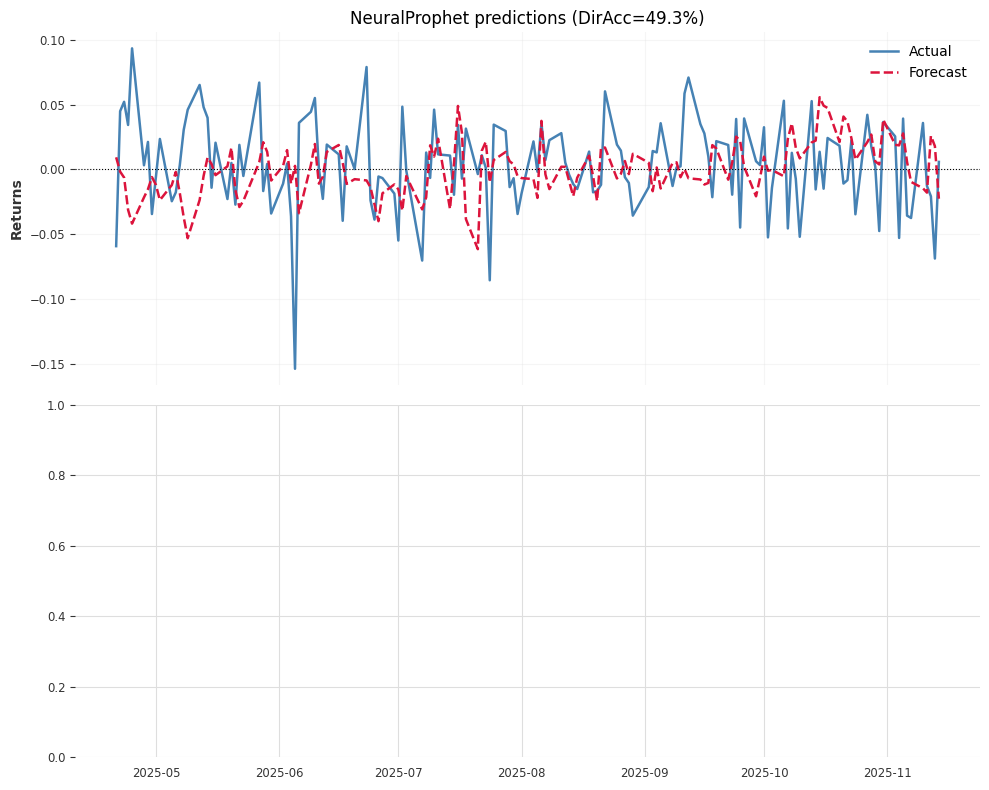

In [208]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

axes[0].plot(test_prophet["ds"], actual_np, label="Actual", color="steelblue", linewidth=1.8)
axes[0].plot(test_prophet["ds"], predictions_np, label="Forecast", color="crimson", linewidth=1.8, linestyle="--")
axes[0].axhline(0, color="black", linestyle=":", linewidth=0.8)
axes[0].set_ylabel("Returns")
axes[0].set_title(f"NeuralProphet predictions (DirAcc={direction_acc_np:.1f}%)")
axes[0].legend()
axes[0].grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [215]:
results_prophet = []
for fold, (train_idx, val_idx) in enumerate(tscv.split(train_prophet)):
    train_df = train_prophet.iloc[train_idx].reset_index(drop=True)
    val_df = train_prophet.iloc[val_idx].reset_index(drop=True)
    model = NeuralProphet(
        n_forecasts=1, n_lags=20, epochs=30, batch_size=32, learning_rate=0.0005,
        trend_reg=3, ar_layers=[32], trend_global_local="global"
    )
    model.add_future_regressor("rsi")
    model.add_future_regressor("volume")
    metrics_df = model.fit(train_df, freq="D", validation_df=val_df, progress="none")
    if "ValLoss" in metrics_df.columns:
        val_loss = metrics_df["ValLoss"].dropna().values[-1]
    else:
        val_loss = metrics_df["Loss"].dropna().values[-1]
    results_prophet.append(val_loss)
print(f"\nProphet-RNN Cross-Validation MSE (val): {results_prophet}")
print(f"Mean: {np.mean(results_prophet):.4f} | Std: {np.std(results_prophet):.4f}")

INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.847% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Added 98 missing dates.
WARNING - (NP.data.processing._handle_missing_data) - 98 missing values in column y were detected in total. 
INFO - (NP.data.processing._handle_missing_data) - 98 NaN values in column y were auto-imputed.
WARNING - (NP.data.processing._handle_missing_data) - 98 missing values in column rsi were detected in total. 
INFO - (NP.data.processing._handle_missing_data) - 98 NaN values in column rsi were auto-imputed.
WARNING - (NP.data.processing._handle_missing_data) - 98 missing values in column volume were detected in total. 


Epoch 30: 100%|██████████| 30/30 [00:00<00:00, 379.74it/s, loss=0.214, v_num=11, MAE_val=0.175, RMSE_val=0.215, Loss_val=0.387, RegLoss_val=0.000, MAE=0.139, RMSE=0.179, Loss=0.219, RegLoss=0.000]  


INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.599% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Added 196 missing dates.
WARNING - (NP.data.processing._handle_missing_data) - 196 missing values in column y were detected in total. 
INFO - (NP.data.processing._handle_missing_data) - 196 NaN values in column y were auto-imputed.
WARNING - (NP.data.processing._handle_missing_data) - 196 missing values in column rsi were detected in total. 
INFO - (NP.data.processing._handle_missing_data) - 196 NaN values in column rsi were auto-imputed.
WARNING - (NP.data.processing._handle_missing_data) - 196 missing values in column volume were detected in to

Epoch 30: 100%|██████████| 30/30 [00:00<00:00, 202.70it/s, loss=0.0719, v_num=12, MAE_val=0.0568, RMSE_val=0.0698, Loss_val=0.0784, RegLoss_val=0.000, MAE=0.0647, RMSE=0.0887, Loss=0.0719, RegLoss=0.000]  


INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.515% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Added 294 missing dates.
WARNING - (NP.data.processing._handle_missing_data) - 294 missing values in column y were detected in total. 
INFO - (NP.data.processing._handle_missing_data) - 294 NaN values in column y were auto-imputed.
WARNING - (NP.data.processing._handle_missing_data) - 294 missing values in column rsi were detected in total. 
INFO - (NP.data.processing._handle_missing_data) - 294 NaN values in column rsi were auto-imputed.
WARNING - (NP.data.processing._handle_missing_data) - 294 missing values in column volume were detected in to

Epoch 30: 100%|██████████| 30/30 [00:00<00:00, 160.43it/s, loss=0.0896, v_num=13, MAE_val=0.0677, RMSE_val=0.0856, Loss_val=0.111, RegLoss_val=0.000, MAE=0.0718, RMSE=0.0915, Loss=0.0886, RegLoss=0.000]  

INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.246% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Added 396 missing dates.
WARNING - (NP.data.processing._handle_missing_data) - 396 missing values in column y were detected in total. 
INFO - (NP.data.processing._handle_missing_data) - 396 NaN values in column y were auto-imputed.
WARNING - (NP.data.processing._handle_missing_data) - 396 missing values in column rsi were detected in total. 
INFO - (NP.data.processing._handle_missing_data) - 396 NaN values in column rsi were auto-imputed.
WARNING - (NP.data.processing._handle_missing_data) - 396 missing values in column volume were detected in to


Epoch 30: 100%|██████████| 30/30 [00:00<00:00, 100.34it/s, loss=0.0553, v_num=14, MAE_val=0.0486, RMSE_val=0.0613, Loss_val=0.0626, RegLoss_val=0.000, MAE=0.0574, RMSE=0.0744, Loss=0.0627, RegLoss=0.000]  

INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.266% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Added 496 missing dates.
WARNING - (NP.data.processing._handle_missing_data) - 496 missing values in column y were detected in total. 
INFO - (NP.data.processing._handle_missing_data) - 496 NaN values in column y were auto-imputed.
WARNING - (NP.data.processing._handle_missing_data) - 496 missing values in column rsi were detected in total. 
INFO - (NP.data.processing._handle_missing_data) - 496 NaN values in column rsi were auto-imputed.
WARNING - (NP.data.processing._handle_missing_data) - 496 missing values in column volume were detected in to


Epoch 30: 100%|██████████| 30/30 [00:00<00:00, 104.90it/s, loss=0.0583, v_num=15, MAE_val=0.0565, RMSE_val=0.074, Loss_val=0.0857, RegLoss_val=0.000, MAE=0.0575, RMSE=0.0787, Loss=0.062, RegLoss=0.000]    

Prophet-RNN Cross-Validation MSE (val): [0.21940389275550842, 0.0718989297747612, 0.08857131749391556, 0.06273749470710754, 0.06196236610412598]
Mean: 0.1009 | Std: 0.0600


## Comparaison des models

In [218]:
# Résumés des résultats de cross-validation
cv_results = {
    "LSTM": results_lstm,
    "GRU": results_gru,
    "ARIMA-LSTM": results_arima_lstm,
    "Prophet-RNN": results_prophet
}

summary = []
for name, scores in cv_results.items():
    summary.append({
        "Modèle": name,
        "Moyenne MSE": np.mean(scores),
        "Écart-type": np.std(scores),
        "Meilleur (min)": np.min(scores),
        "Moins bon (max)": np.max(scores)
    })

df_summary = pd.DataFrame(summary)
df_summary = df_summary.sort_values("Moyenne MSE")
print(df_summary)


        Modèle  Moyenne MSE  Écart-type  Meilleur (min)  Moins bon (max)
2   ARIMA-LSTM     0.001521    0.000433        0.001000         0.002137
3  Prophet-RNN     0.100915    0.060015        0.061962         0.219404
1          GRU     0.821981    0.281476        0.452626         1.251075
0         LSTM     0.828988    0.285913        0.461694         1.274096
